In [2]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = 100
import re
# from venn import venn
from scipy.stats import pearsonr, spearmanr, ttest_rel
import seaborn as sns
import matplotlib.pyplot as plt
import qgrid

In [3]:
# mpl.rcParams['font.family'] = 'Avenir'
plt.rc('font', family='Helvetica')
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.figsize'] = (10.0, 7.0)
sns.set_palette("Dark2")

# load data

In [40]:
ic50 = pd.read_csv("../data/drug/final_drug_scores.tsv")

meta = pd.read_csv("../data/E0022_P06_final_sample_map.txt", sep='\t')
tissue_types = meta[['Cell_line', 'Tissue_type']].drop_duplicates()
# protein_raw = pd.read_csv("../data/protein/E0022_P06_log_transformed.tsv", sep='\t')
# protein_raw_median = pd.read_csv("../data/protein/E0022_P06_Protein_Matrix_RawMedian_no_control.txt", sep='\t')
# protein_median = pd.read_csv("../data/protein/E0022_P06_Protein_Matrix_Median_no_control.txt", sep='\t')
protein_RUV = pd.read_csv(
    "../data/protein/E0022_P06_Protein_Matrix_ProNorM_no_control_update.txt",
    sep='\t')
cell_line_train = pd.read_csv(
    "../data/protein/E0022_P06_Protein_Matrix_ProNorM_no_control_train.txt",
    sep='\t')['Cell_line']
cell_line_test = pd.read_csv(
    "../data/protein/E0022_P06_Protein_Matrix_ProNorM_no_control_test.txt",
    sep='\t')['Cell_line']
ccle_drug = pd.read_csv("../data/ccle/drug_all_ccle_secondary_processed_auc.csv")

In [68]:
df_broad = pd.read_csv('../data/ccle/protein_quant_current_normalized.csv')
df_broad = df_broad.drop(
    ['Protein_Id', 'Gene_Symbol', 'Description', 'Group_ID', 'Uniprot_Acc'],
    axis=1).rename(columns={
        'Uniprot': 'Protein'
    }).set_index('Protein')
df_broad = df_broad.drop([
    'SW948_LARGE_INTESTINE_TenPx11', 'CAL120_BREAST_TenPx02',
    'HCT15_LARGE_INTESTINE_TenPx30'
],
                         axis=1)
rename_dict = {}
for x in df_broad.columns.to_list():
    rename_dict[x] = x.split('_TenPx')[0]
df_broad = df_broad.rename(columns=rename_dict)
df_broad = df_broad.drop(
    [x for x in df_broad.columns.tolist() if 'TenPx' in x],
    axis=1).transpose()

curr_dict = meta[['CCLE_ID','Cell_line']].drop_duplicates().set_index('CCLE_ID').to_dict()['Cell_line']
df_broad.index = df_broad.index.map(curr_dict)

common_lines_broad = [x for x in df_broad.index.tolist() if x in protein_RUV['Cell_line'].values]
print('Number of common cell lines: ',len(common_lines_broad))

len(set(common_lines_broad))
df_broad.index.name = 'Cell_line'
ccle_protein = df_broad.reset_index()

Number of common cell lines:  295


In [69]:
name_map = pd.read_csv("../data/misc/HUMAN_9606_idmapping.gene_prot.dat",
                       sep='\t',
                       names=['ID', 'type', 'code'])
name_map = name_map.drop_duplicates(['ID', 'type'])
name_map = pd.pivot(name_map, index='ID', columns='type', values='code').dropna()

name_map_dict = dict(zip(name_map['UniProtKB-ID'].values, name_map['Gene_Name'].values))

In [6]:
df_broad.to_csv("../data/ccle/ccle_proteins_sanger_name.csv")

In [70]:
mapped_proteins = list(set(df_broad.columns).intersection(name_map_dict.keys()))

df_broad_genename = df_broad[mapped_proteins]
df_broad_genename.columns = [name_map_dict[x] for x in df_broad_genename.columns]
df_broad_genename.to_csv("../data/ccle/ccle_proteins_sanger_name_genename.csv")

In [71]:
df_broad_genename.to_csv("../../SangerTMM/data/ccle_proteins_sanger_name_genename.csv")

In [38]:
len(set(common_lines_broad).intersection(cell_line_train))

252

In [39]:
len(set(common_lines_broad).intersection(cell_line_test))

43

# correlations

## raw_median normalised

In [357]:
protein_sanger = protein_raw_median
cell_line_dict = {"Sanger":set(protein_sanger['Cell_line'].unique()),
                 "CCLE":set(ccle_protein['Cell_line'].unique())}

common_cell_lines = list(
    set(protein_sanger['Cell_line'].unique()).intersection(
        set(ccle_protein['Cell_line'].unique())))

common_proteins = list(
    set(protein_sanger.drop(['Cell_line'], axis=1).columns).intersection(
        set(ccle_protein.drop(['Cell_line'], axis=1).columns)))

len(common_cell_lines)

295

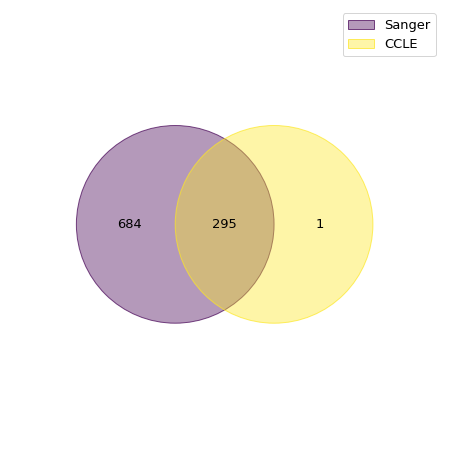

In [358]:
venn(cell_line_dict)

In [359]:
ccle_protein_melt = pd.melt(ccle_protein, id_vars='Cell_line', value_name='CCLE_protein', var_name='protein')

In [360]:
sanger_protein_melt = pd.melt(protein_sanger,
                              id_vars='Cell_line',
                              value_name='Sanger_protein',
                              var_name='protein')

In [361]:
combined = pd.merge(ccle_protein_melt, sanger_protein_melt, on=['Cell_line', 'protein'])

combined = combined.dropna()

combined = pd.merge(combined, tissue_types)

In [362]:
spearmanr(combined['CCLE_protein'], combined['Sanger_protein'])

SpearmanrResult(correlation=0.4177725812875462, pvalue=0.0)

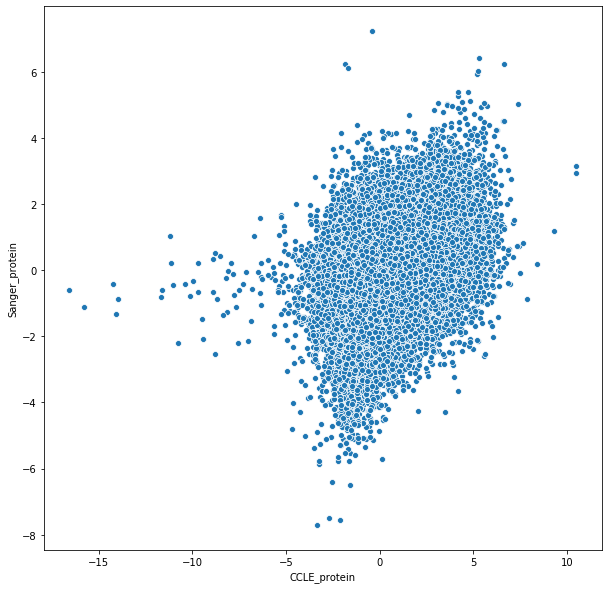

In [264]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x='CCLE_protein',
                y='Sanger_protein',
                data=combined)

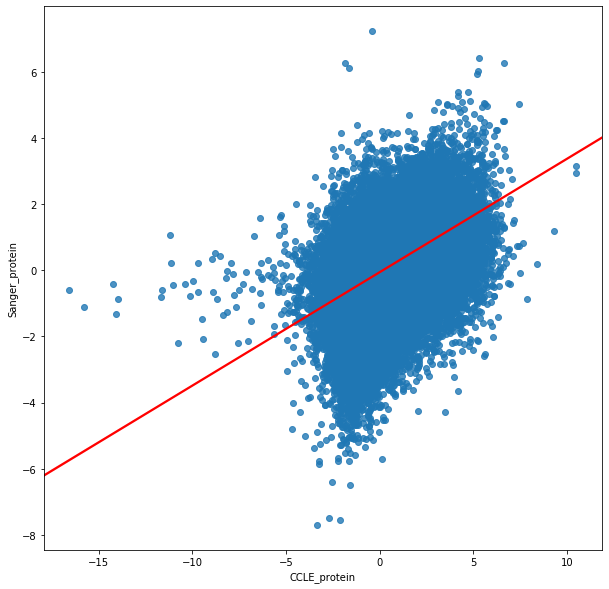

In [265]:
plt.figure(figsize=(10, 10))
sns.regplot('CCLE_protein', 'Sanger_protein', combined,
            line_kws={'color': 'red'})

In [363]:
ccle_protein_common = ccle_protein[ccle_protein['Cell_line'].isin(common_cell_lines)]
ccle_protein_common = pd.concat([ccle_protein_common['Cell_line'], ccle_protein_common[common_proteins]], axis=1)
ccle_protein_common = ccle_protein_common.drop_duplicates(['Cell_line'])
ccle_protein_common = ccle_protein_common.loc[:,~ccle_protein_common.columns.duplicated()]

# ccle_protein_common.to_csv("../data/ccle/protein_matrix_common.tsv", index=False, sep='\t')

In [364]:
protein_sanger_common = protein_sanger[
    protein_sanger['Cell_line'].isin(common_cell_lines)]
protein_sanger_common = pd.concat([
    protein_sanger_common['Cell_line'],
    protein_sanger_common[common_proteins]
],
                                      axis=1)

# protein_sanger_common.to_csv("../data/protein/P06_matrix_common.tsv",
#                                  index=False,
#                                  sep='\t')

In [365]:
ccle_protein_common = ccle_protein_common[ccle_protein_common['Cell_line'].isin(
    common_cell_lines)].drop_duplicates('Cell_line')
sanger_protein_common = protein_sanger[
    protein_sanger['Cell_line'].isin(common_cell_lines)]

In [366]:
ccle_protein_common = ccle_protein_common.sort_values(
    by=['Cell_line']).reset_index(drop=True)
sanger_protein_common = sanger_protein_common.sort_values(
    by=['Cell_line']).reset_index(drop=True)

In [367]:
corr_dict = {}
for protein in common_proteins:
    tmp_df_dict = {}
    tmp_df_dict['sanger'] = list(sanger_protein_common[protein].values)
    tmp_df_dict['ccle'] = list(ccle_protein_common[protein].values)
    tmp_df = pd.DataFrame(tmp_df_dict)
    tmp_df = tmp_df.dropna()
    corr = spearmanr(tmp_df['sanger'].values,
                                   tmp_df['ccle'].values)[0]
    if not np.isnan(corr):
        corr_dict[protein] = corr

Text(-1.0, 300, 'Median: 0.4275')

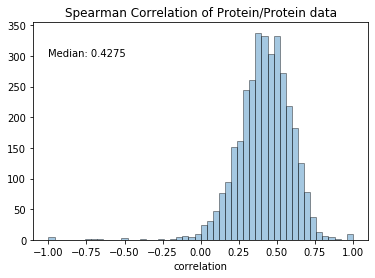

In [368]:
sns.distplot(list(corr_dict.values()),
             kde=False,
             hist_kws=dict(edgecolor="k", linewidth=1))
plt.title("Spearman Correlation of Protein/Protein data")
plt.xlabel("correlation")
plt.text(np.min(list(corr_dict.values())), 300,
         f"Median: {np.median(list(corr_dict.values())):.4f}")

## median

In [42]:
protein_sanger = protein_median
cell_line_dict = {"Sanger":set(protein_sanger['Cell_line'].unique()),
                 "CCLE":set(ccle_protein['Cell_line'].unique())}

common_cell_lines = list(
    set(protein_sanger['Cell_line'].unique()).intersection(
        set(ccle_protein['Cell_line'].unique())))

common_proteins = list(
    set(protein_sanger.drop(['Cell_line'], axis=1).columns).intersection(
        set(ccle_protein.drop(['Cell_line'], axis=1).columns)))

len(common_proteins)

2966

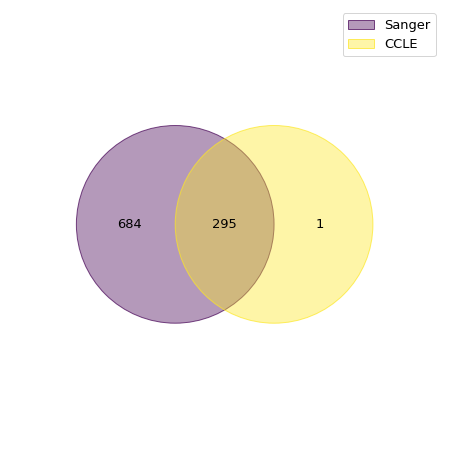

In [43]:
venn(cell_line_dict)

In [44]:
ccle_protein_melt = pd.melt(ccle_protein, id_vars='Cell_line', value_name='CCLE_protein', var_name='protein')

In [45]:
sanger_protein_melt = pd.melt(protein_sanger,
                              id_vars='Cell_line',
                              value_name='Sanger_protein',
                              var_name='protein')

In [46]:
combined = pd.merge(ccle_protein_melt, sanger_protein_melt, on=['Cell_line', 'protein'])

combined = combined.dropna()

combined = pd.merge(combined, tissue_types)

In [47]:
spearmanr(combined['CCLE_protein'], combined['Sanger_protein'])

SpearmanrResult(correlation=0.4341765319466016, pvalue=0.0)

Text(-15, 6, 'Spearman R: 0.4342')

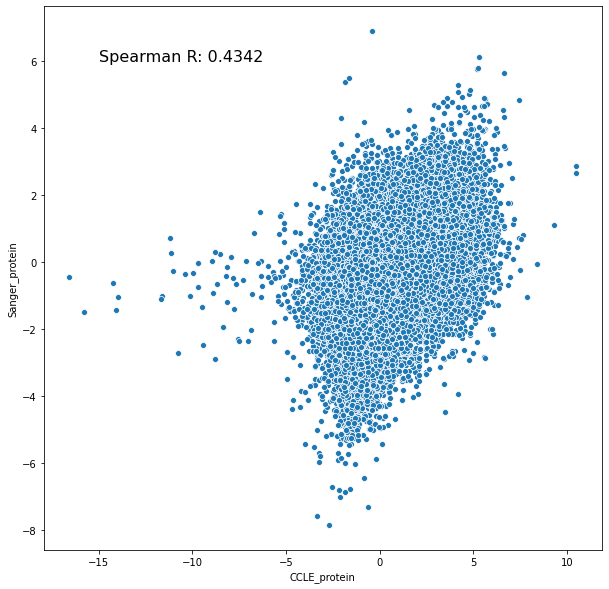

In [48]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x='CCLE_protein',
                y='Sanger_protein',
                data=combined)
plt.text(-15, 6,
         f"Spearman R: {spearmanr(combined['CCLE_protein'], combined['Sanger_protein'])[0]:.4f}",fontsize=16)

In [ ]:
plt.figure(figsize=(10, 10))
sns.regplot('CCLE_protein', 'Sanger_protein', combined,
            line_kws={'color': 'red'})

In [350]:
ccle_protein_common = ccle_protein[ccle_protein['Cell_line'].isin(common_cell_lines)]
ccle_protein_common = pd.concat([ccle_protein_common['Cell_line'], ccle_protein_common[common_proteins]], axis=1)
ccle_protein_common = ccle_protein_common.drop_duplicates(['Cell_line'])
ccle_protein_common = ccle_protein_common.loc[:,~ccle_protein_common.columns.duplicated()]
# ccle_protein_common.to_csv("../data/ccle/protein_matrix_common.tsv", index=False, sep='\t')

In [352]:
protein_sanger_common = protein_sanger[common_proteins]
protein_sanger_common = protein_sanger[
    protein_sanger['Cell_line'].isin(common_cell_lines)]
protein_sanger_common = pd.concat([
    protein_sanger_common['Cell_line'],
    protein_sanger_common[common_proteins]
],
                                      axis=1)

# protein_sanger_common.to_csv("../data/protein/P06_matrix_common.tsv",
#                                  index=False,
#                                  sep='\t')

In [353]:
ccle_protein_common = ccle_protein_common[ccle_protein_common['Cell_line'].isin(
    common_cell_lines)].drop_duplicates('Cell_line')
sanger_protein_common = protein_sanger[
    protein_sanger['Cell_line'].isin(common_cell_lines)]

In [354]:
ccle_protein_common = ccle_protein_common.sort_values(
    by=['Cell_line']).reset_index(drop=True)
sanger_protein_common = sanger_protein_common.sort_values(
    by=['Cell_line']).reset_index(drop=True)

In [355]:
corr_dict = {}
for protein in common_proteins:
    tmp_df_dict = {}
    tmp_df_dict['sanger'] = list(sanger_protein_common[protein].values)
    tmp_df_dict['ccle'] = list(ccle_protein_common[protein].values)
    tmp_df = pd.DataFrame(tmp_df_dict)
    tmp_df = tmp_df.dropna()
    corr = spearmanr(tmp_df['sanger'].values,
                                   tmp_df['ccle'].values)[0]
    if not np.isnan(corr):
        corr_dict[protein] = corr

Text(-1.0, 300, 'Median: 0.4542')

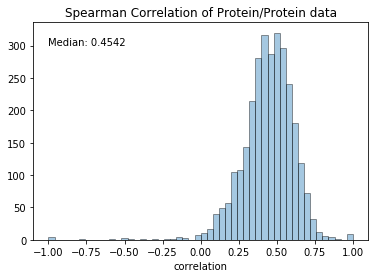

In [356]:
sns.distplot(list(corr_dict.values()),
             kde=False,
             hist_kws=dict(edgecolor="k", linewidth=1))
plt.title("Spearman Correlation of Protein/Protein data")
plt.xlabel("correlation")
plt.text(np.min(list(corr_dict.values())), 300,
         f"Median: {np.median(list(corr_dict.values())):.4f}")

## RUV

In [47]:
protein_sanger = protein_RUV
cell_line_dict = {"Sanger":set(protein_sanger['Cell_line'].unique()),
                 "CCLE":set(ccle_protein['Cell_line'].unique())}

common_cell_lines = list(
    set(protein_sanger['Cell_line'].unique()).intersection(
        set(ccle_protein['Cell_line'].unique())))

common_proteins = list(
    set(protein_sanger.drop(['Cell_line'], axis=1).columns).intersection(
        set(ccle_protein.drop(['Cell_line'], axis=1).columns)))

len(common_proteins)

3232

In [9]:
ccle_protein_melt = pd.melt(ccle_protein, id_vars='Cell_line', value_name='CCLE_protein', var_name='protein')

In [10]:
sanger_protein_melt = pd.melt(protein_sanger,
                              id_vars='Cell_line',
                              value_name='Sanger_protein',
                              var_name='protein')

In [11]:
combined = pd.merge(ccle_protein_melt, sanger_protein_melt, on=['Cell_line', 'protein'])

combined = combined.dropna()

combined = pd.merge(combined, tissue_types)

In [12]:
spearmanr(combined['CCLE_protein'], combined['Sanger_protein'])

SpearmanrResult(correlation=0.4132722297296529, pvalue=0.0)

Text(-15, 6, 'Spearman R: 0.4128')

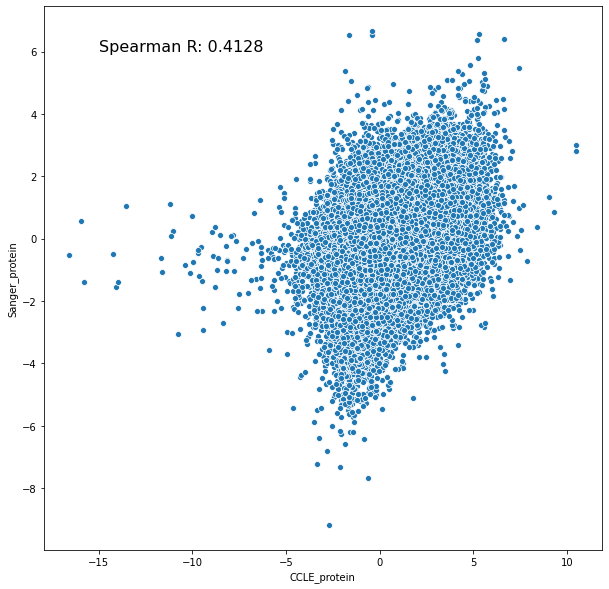

In [41]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x='CCLE_protein',
                y='Sanger_protein',
                data=combined)
plt.text(-15, 6,
         f"Spearman R: {spearmanr(combined['CCLE_protein'], combined['Sanger_protein'])[0]:.4f}",fontsize=16)

In [ ]:
plt.figure(figsize=(10, 10))
sns.regplot('CCLE_protein', 'Sanger_protein', combined,
            line_kws={'color': 'red'})

In [13]:
ccle_protein[ccle_protein['Cell_line'].isin(common_cell_lines)].to_csv(
    "../data/ccle/protein_matrix_common_all_proteins.tsv", index=False, sep='\t')

In [14]:
ccle_protein_common = ccle_protein[ccle_protein['Cell_line'].isin(common_cell_lines)]
ccle_protein_common = pd.concat([ccle_protein_common['Cell_line'], ccle_protein_common[common_proteins]], axis=1)
ccle_protein_common = ccle_protein_common.drop_duplicates(['Cell_line'])
ccle_protein_common = ccle_protein_common.loc[:,~ccle_protein_common.columns.duplicated()]
ccle_protein_common.to_csv("../data/ccle/protein_matrix_common_ruv.tsv", index=False, sep='\t')

In [15]:
protein_sanger_common = protein_sanger[common_proteins]
protein_sanger_common = protein_sanger[
    protein_sanger['Cell_line'].isin(common_cell_lines)]
protein_sanger_common = pd.concat([
    protein_sanger_common['Cell_line'],
    protein_sanger_common[common_proteins]
],
                                      axis=1)

protein_sanger_common.to_csv("../data/protein/common_ccle_ruv_final.tsv",
                                 index=False,
                                 sep='\t')

In [16]:
ccle_protein_common = ccle_protein_common[ccle_protein_common['Cell_line'].isin(
    common_cell_lines)].drop_duplicates('Cell_line')
sanger_protein_common = protein_sanger[
    protein_sanger['Cell_line'].isin(common_cell_lines)]

In [17]:
ccle_protein_common = ccle_protein_common.sort_values(
    by=['Cell_line']).reset_index(drop=True)
sanger_protein_common = sanger_protein_common.sort_values(
    by=['Cell_line']).reset_index(drop=True)

In [18]:
corr_dict = {}
for protein in common_proteins:
    tmp_df_dict = {}
    tmp_df_dict['sanger'] = list(sanger_protein_common[protein].values)
    tmp_df_dict['ccle'] = list(ccle_protein_common[protein].values)
    tmp_df = pd.DataFrame(tmp_df_dict)
    tmp_df = tmp_df.dropna()
    corr = spearmanr(tmp_df['sanger'].values,
                                   tmp_df['ccle'].values)[0]
    if not np.isnan(corr):
        corr_dict[protein] = corr

Text(-0.9999999999999999, 300, 'Median: 0.4288')

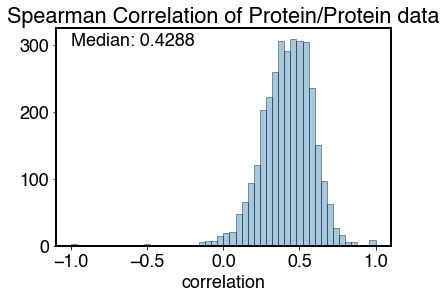

In [19]:
sns.distplot(list(corr_dict.values()),
             kde=False,
             hist_kws=dict(edgecolor="k", linewidth=1))
plt.title("Spearman Correlation of Protein/Protein data")
plt.xlabel("correlation")
plt.text(np.min(list(corr_dict.values())), 300,
         f"Median: {np.median(list(corr_dict.values())):.4f}")

## RUV vs median common

### median

In [385]:
protein_sanger = protein_median[median_ruv_common]
cell_line_dict = {"Sanger":set(protein_sanger['Cell_line'].unique()),
                 "CCLE":set(ccle_protein['Cell_line'].unique())}

common_cell_lines = list(
    set(protein_sanger['Cell_line'].unique()).intersection(
        set(ccle_protein['Cell_line'].unique())))

common_proteins = list(
    set(protein_sanger.drop(['Cell_line'], axis=1).columns).intersection(
        set(ccle_protein.drop(['Cell_line'], axis=1).columns)))

len(common_proteins)

2935

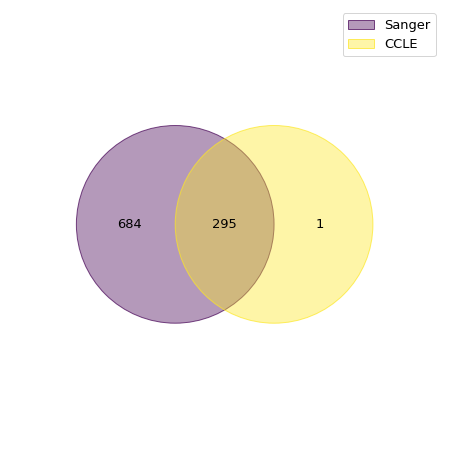

In [386]:
venn(cell_line_dict)

In [387]:
ccle_protein_melt = pd.melt(ccle_protein, id_vars='Cell_line', value_name='CCLE_protein', var_name='protein')

In [388]:
sanger_protein_melt = pd.melt(protein_sanger,
                              id_vars='Cell_line',
                              value_name='Sanger_protein',
                              var_name='protein')

In [389]:
combined = pd.merge(ccle_protein_melt, sanger_protein_melt, on=['Cell_line', 'protein'])

combined = combined.dropna()

combined = pd.merge(combined, tissue_types)

In [390]:
spearmanr(combined['CCLE_protein'], combined['Sanger_protein'])

SpearmanrResult(correlation=0.4353661349000104, pvalue=0.0)

In [ ]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x='CCLE_protein',
                y='Sanger_protein',
                data=combined)

In [ ]:
plt.figure(figsize=(10, 10))
sns.regplot('CCLE_protein', 'Sanger_protein', combined,
            line_kws={'color': 'red'})

In [391]:
ccle_protein_common = ccle_protein[ccle_protein['Cell_line'].isin(common_cell_lines)]
ccle_protein_common = pd.concat([ccle_protein_common['Cell_line'], ccle_protein_common[common_proteins]], axis=1)
ccle_protein_common = ccle_protein_common.drop_duplicates(['Cell_line'])
ccle_protein_common = ccle_protein_common.loc[:,~ccle_protein_common.columns.duplicated()]
# ccle_protein_common.to_csv("../data/ccle/protein_matrix_common.tsv", index=False, sep='\t')

In [392]:
protein_sanger_common = protein_sanger[common_proteins]
protein_sanger_common = protein_sanger[
    protein_sanger['Cell_line'].isin(common_cell_lines)]
protein_sanger_common = pd.concat([
    protein_sanger_common['Cell_line'],
    protein_sanger_common[common_proteins]
],
                                      axis=1)

# protein_sanger_common.to_csv("../data/protein/P06_matrix_common.tsv",
#                                  index=False,
#                                  sep='\t')

In [393]:
ccle_protein_common = ccle_protein_common[ccle_protein_common['Cell_line'].isin(
    common_cell_lines)].drop_duplicates('Cell_line')
sanger_protein_common = protein_sanger[
    protein_sanger['Cell_line'].isin(common_cell_lines)]

In [394]:
ccle_protein_common = ccle_protein_common.sort_values(
    by=['Cell_line']).reset_index(drop=True)
sanger_protein_common = sanger_protein_common.sort_values(
    by=['Cell_line']).reset_index(drop=True)

In [395]:
corr_dict = {}
for protein in common_proteins:
    tmp_df_dict = {}
    tmp_df_dict['sanger'] = list(sanger_protein_common[protein].values)
    tmp_df_dict['ccle'] = list(ccle_protein_common[protein].values)
    tmp_df = pd.DataFrame(tmp_df_dict)
    tmp_df = tmp_df.dropna()
    corr = spearmanr(tmp_df['sanger'].values,
                                   tmp_df['ccle'].values)[0]
    if not np.isnan(corr):
        corr_dict[protein] = corr

Text(-1.0, 300, 'Median: 0.4561')

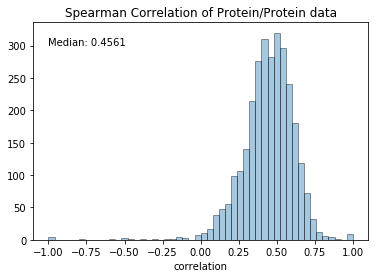

In [396]:
sns.distplot(list(corr_dict.values()),
             kde=False,
             hist_kws=dict(edgecolor="k", linewidth=1))
plt.title("Spearman Correlation of Protein/Protein data")
plt.xlabel("correlation")
plt.text(np.min(list(corr_dict.values())), 300,
         f"Median: {np.median(list(corr_dict.values())):.4f}")

### RUV

In [397]:
protein_sanger = protein_RUV[median_ruv_common]
cell_line_dict = {"Sanger":set(protein_sanger['Cell_line'].unique()),
                 "CCLE":set(ccle_protein['Cell_line'].unique())}

common_cell_lines = list(
    set(protein_sanger['Cell_line'].unique()).intersection(
        set(ccle_protein['Cell_line'].unique())))

common_proteins = list(
    set(protein_sanger.drop(['Cell_line'], axis=1).columns).intersection(
        set(ccle_protein.drop(['Cell_line'], axis=1).columns)))

len(common_proteins)

2935

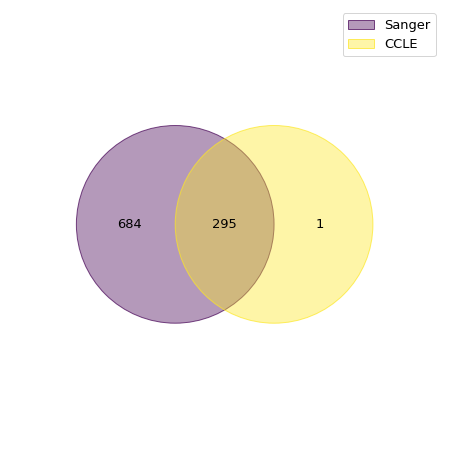

In [398]:
venn(cell_line_dict)

In [399]:
ccle_protein_melt = pd.melt(ccle_protein, id_vars='Cell_line', value_name='CCLE_protein', var_name='protein')

In [400]:
sanger_protein_melt = pd.melt(protein_sanger,
                              id_vars='Cell_line',
                              value_name='Sanger_protein',
                              var_name='protein')

In [401]:
combined = pd.merge(ccle_protein_melt, sanger_protein_melt, on=['Cell_line', 'protein'])

combined = combined.dropna()

combined = pd.merge(combined, tissue_types)

In [402]:
spearmanr(combined['CCLE_protein'], combined['Sanger_protein'])

SpearmanrResult(correlation=0.4193009295880735, pvalue=0.0)

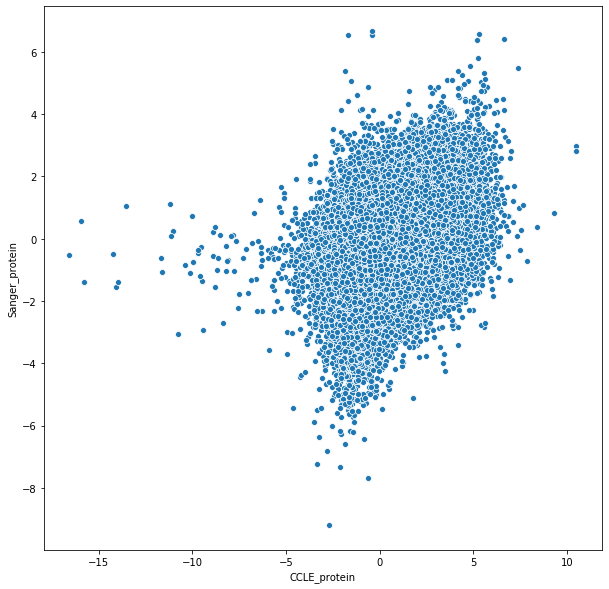

In [403]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x='CCLE_protein',
                y='Sanger_protein',
                data=combined)

In [ ]:
plt.figure(figsize=(10, 10))
sns.regplot('CCLE_protein', 'Sanger_protein', combined,
            line_kws={'color': 'red'})

In [404]:
ccle_protein_common = ccle_protein[ccle_protein['Cell_line'].isin(common_cell_lines)]
ccle_protein_common = pd.concat([ccle_protein_common['Cell_line'], ccle_protein_common[common_proteins]], axis=1)
ccle_protein_common = ccle_protein_common.drop_duplicates(['Cell_line'])
ccle_protein_common = ccle_protein_common.loc[:,~ccle_protein_common.columns.duplicated()]
# ccle_protein_common.to_csv("../data/ccle/protein_matrix_common.tsv", index=False, sep='\t')

In [405]:
protein_sanger_common = protein_sanger[common_proteins]
protein_sanger_common = protein_sanger[
    protein_sanger['Cell_line'].isin(common_cell_lines)]
protein_sanger_common = pd.concat([
    protein_sanger_common['Cell_line'],
    protein_sanger_common[common_proteins]
],
                                      axis=1)

# protein_sanger_common.to_csv("../data/protein/P06_matrix_common.tsv",
#                                  index=False,
#                                  sep='\t')

In [406]:
ccle_protein_common = ccle_protein_common[ccle_protein_common['Cell_line'].isin(
    common_cell_lines)].drop_duplicates('Cell_line')
sanger_protein_common = protein_sanger[
    protein_sanger['Cell_line'].isin(common_cell_lines)]

In [407]:
ccle_protein_common = ccle_protein_common.sort_values(
    by=['Cell_line']).reset_index(drop=True)
sanger_protein_common = sanger_protein_common.sort_values(
    by=['Cell_line']).reset_index(drop=True)

In [408]:
corr_dict = {}
for protein in common_proteins:
    tmp_df_dict = {}
    tmp_df_dict['sanger'] = list(sanger_protein_common[protein].values)
    tmp_df_dict['ccle'] = list(ccle_protein_common[protein].values)
    tmp_df = pd.DataFrame(tmp_df_dict)
    tmp_df = tmp_df.dropna()
    corr = spearmanr(tmp_df['sanger'].values,
                                   tmp_df['ccle'].values)[0]
    if not np.isnan(corr):
        corr_dict[protein] = corr

Text(-0.9999999999999999, 300, 'Median: 0.4381')

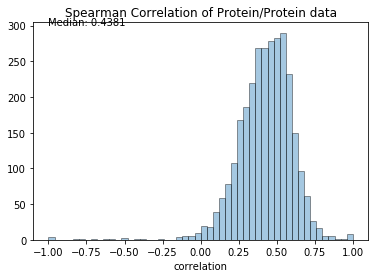

In [409]:
sns.distplot(list(corr_dict.values()),
             kde=False,
             hist_kws=dict(edgecolor="k", linewidth=1))
plt.title("Spearman Correlation of Protein/Protein data")
plt.xlabel("correlation")
plt.text(np.min(list(corr_dict.values())), 300,
         f"Median: {np.median(list(corr_dict.values())):.4f}")

# model comparison

## all drug

In [7]:
ccle_score_sanger_drug = pd.read_csv(
    "../work_dirs/vs_ccle/sanger_drug/RandomForest/scores_202006221426_ccle_all_zero_300_eg_id.csv"
)
sanger_score_sanger_drug = pd.read_csv(
    "../work_dirs/vs_ccle/sanger_drug/RandomForest/scores_202006221052_sanger_common_ruv_zero_300_eg_id.csv"
)
ccle_score_sanger_drug['protein_data'] = 'CCLE'
sanger_score_sanger_drug['protein_data'] = 'ProCan&Sanger'

In [8]:
sanger_all_drug = pd.concat([ccle_score_sanger_drug, sanger_score_sanger_drug])

In [9]:
ccle_score_ctd_drug = pd.read_csv(
    "../work_dirs/vs_ccle/ctd_drug/RandomForest/scores_202009101112_ccle_ctd_auc.csv"
)
sanger_score_ctd_drug = pd.read_csv(
    "../work_dirs/vs_ccle/ctd_drug/RandomForest/scores_202009101113_sanger_ruv_ctd_auc.csv"
)
ccle_score_ctd_drug['protein_data'] = 'CCLE'
sanger_score_ctd_drug['protein_data'] = 'ProCan&Sanger'

In [10]:
ctd_all_drug = pd.concat([ccle_score_ctd_drug, sanger_score_ctd_drug])

In [11]:
ttest_rel(ctd_all_drug[ctd_all_drug['protein_data']=='CCLE']['test_corr'].values,
          ctd_all_drug[ctd_all_drug['protein_data']=='ProCan&Sanger']['test_corr'].values)

Ttest_relResult(statistic=2.3186245787895974, pvalue=0.020785132702879995)

In [12]:
ccle_score_ccle_drug = pd.read_csv(
    "../work_dirs/vs_ccle/ccle_drug/RandomForest/scores_202006102105_ccle_all_min_secondary_AUC.csv"
)
sanger_score_ccle_drug = pd.read_csv(
    "../work_dirs/vs_ccle/ccle_drug/RandomForest/scores_202006102122_ruv_prism_min_secondary_AUC.csv"
)
ccle_score_ccle_drug['protein_data'] = 'CCLE'
sanger_score_ccle_drug['protein_data'] = 'ProCan&Sanger'
ccle_all_drug = pd.concat([ccle_score_ccle_drug, sanger_score_ccle_drug])

In [13]:
ttest_rel(sanger_all_drug[sanger_all_drug['protein_data']=='CCLE']['test_corr'].values,
          sanger_all_drug[sanger_all_drug['protein_data']=='ProCan&Sanger']['test_corr'].values)

Ttest_relResult(statistic=-4.32567406959877, pvalue=1.738894855669056e-05)

In [14]:
ttest_rel(ccle_all_drug[ccle_all_drug['protein_data']=='CCLE']['test_corr'].values,
          ccle_all_drug[ccle_all_drug['protein_data']=='ProCan&Sanger']['test_corr'].values)

Ttest_relResult(statistic=0.32170002160628147, pvalue=0.7477284004878575)

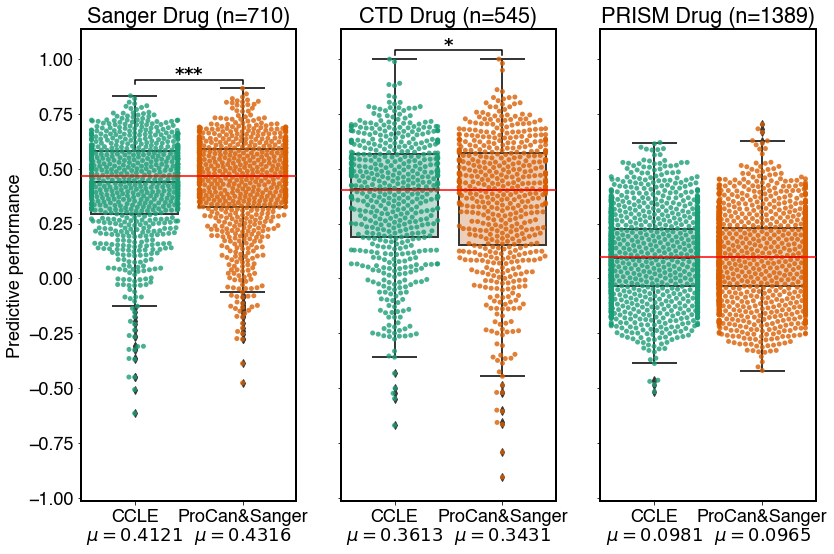

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(12, 8), sharey=True)

ga = sns.boxplot('protein_data',
                 'test_corr',
                 data=sanger_all_drug,
                 orient='v',
                 linewidth=2,
                 ax=ax[0])
for patch in ga.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))

sns.swarmplot('protein_data',
              'test_corr',
              data=sanger_all_drug,
              orient='vh',
              alpha=.8,
              ax=ax[0])

x1, x2 = 0, 1  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = sanger_all_drug['test_corr'].max() + 0.02, 0.02, 'k'
ax[0].plot([x1, x1, x2, x2], [y, y + w, y + w, y], lw=1.5, c=col)
ax[0].text((x1 + x2) * .5,
           y + w + 0.03,
           r"$\bf{*}\bf{*}\bf{*}$",
           ha='center',
           va='center',
           color=col)
ax[0].text(
    0,
    ctd_all_drug['test_corr'].min() - 0.27,
    f"$\mu={sanger_all_drug[sanger_all_drug['protein_data']=='CCLE']['test_corr'].mean():.4f}$",
    ha='center',
    va='center')
ax[0].text(
    1,
    ctd_all_drug['test_corr'].min() - 0.27,
    f"$\mu={sanger_all_drug[sanger_all_drug['protein_data']=='ProCan&Sanger']['test_corr'].mean():.4f}$",
    ha='center',
    va='center')
y = sanger_all_drug[sanger_all_drug['protein_data'] ==
                    'ProCan&Sanger']['test_corr'].median()
ax[0].plot((-0.5, 2.5), [y, y], color='red', zorder=10)

ga = sns.boxplot('protein_data',
                 'test_corr',
                 data=ctd_all_drug,
                 orient='v',
                 linewidth=2,
                 ax=ax[1])
for patch in ga.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))

sns.swarmplot('protein_data',
              'test_corr',
              data=ctd_all_drug,
              orient='vh',
              alpha=.8,
              ax=ax[1])

y = ctd_all_drug[ctd_all_drug['protein_data'] ==
                  'ProCan&Sanger']['test_corr'].median()
ax[1].plot((-0.5, 2.5), [y, y], color='red', zorder=10)
ax[1].text(
    0,
    ctd_all_drug['test_corr'].min() - 0.27,
    f"$\mu={ctd_all_drug[ctd_all_drug['protein_data']=='CCLE']['test_corr'].mean():.4f}$",
    ha='center',
    va='center')
ax[1].text(
    1,
    ctd_all_drug['test_corr'].min() - 0.27,
    f"$\mu={ctd_all_drug[ctd_all_drug['protein_data']=='ProCan&Sanger']['test_corr'].mean():.4f}$",
    ha='center',
    va='center')
x1, x2 = 0, 1  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = ctd_all_drug['test_corr'].max() + 0.02, 0.02, 'k'
ax[1].plot([x1, x1, x2, x2], [y, y + w, y + w, y], lw=1.5, c=col)
ax[1].text((x1 + x2) * .5,
           y + w + 0.03,
           r"$\bf{*}$",
           ha='center',
           va='center',
           color=col)

ga = sns.boxplot('protein_data',
                 'test_corr',
                 data=ccle_all_drug,
                 orient='v',
                 linewidth=2,
                 ax=ax[2])
for patch in ga.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))

sns.swarmplot('protein_data',
              'test_corr',
              data=ccle_all_drug,
              orient='vh',
              alpha=.8,
              ax=ax[2])

y = ccle_all_drug[ccle_all_drug['protein_data'] ==
                  'ProCan&Sanger']['test_corr'].median()
ax[2].plot((-0.5, 2.5), [y, y], color='red', zorder=10)
ax[2].text(
    0,
    ctd_all_drug['test_corr'].min() - 0.27,
    f"$\mu={ccle_all_drug[ccle_all_drug['protein_data']=='CCLE']['test_corr'].mean():.4f}$",
    ha='center',
    va='center')
ax[2].text(
    1,
    ctd_all_drug['test_corr'].min() - 0.27,
    f"$\mu={ccle_all_drug[ccle_all_drug['protein_data']=='ProCan&Sanger']['test_corr'].mean():.4f}$",
    ha='center',
    va='center')

ax[0].set_title(f"Sanger Drug (n={sanger_all_drug['drug_id'].unique().size})")
ax[1].set_title(f"CTD Drug (n={ctd_all_drug['drug_id'].unique().size})")
ax[2].set_title(f"PRISM Drug (n={ccle_all_drug['drug_id'].unique().size})")

ax[0].set_xlabel("")
ax[1].set_xlabel("")
ax[2].set_xlabel("")
ax[0].set_ylabel("Predictive performance")
ax[1].set_ylabel("")
ax[2].set_ylabel("")
plt.tight_layout()
# plt.savefig("../plots/drug/sanger_vs_ccle.pdf", dpi=500)

In [16]:
ctd_all_drug['drug_data'] = 'CTD'
sanger_all_drug['drug_data'] = 'Sanger'
ccle_all_drug['drug_data'] = 'PRISM'
combined_df = pd.concat(
    [sanger_all_drug, ctd_all_drug,
     ccle_all_drug])[['drug_id', 'test_corr', 'protein_data', 'drug_data']]

In [66]:
combined_df.to_csv("../plots/plot_data/Fig4B_drug_sanger_ctd_prism_box.csv",
                   index=False)

In [17]:
sanger_all_drug_scatter = pd.pivot(
    sanger_all_drug[['drug_id', 'test_corr', 'protein_data']],
    index='drug_id',
    columns='protein_data',
    values='test_corr')

sanger_all_drug_scatter['delta'] = sanger_all_drug_scatter[
    'ProCan&Sanger'] - sanger_all_drug_scatter['CCLE']

In [18]:
ccle_all_drug_scatter = pd.pivot(
    ccle_all_drug[['drug_id', 'test_corr', 'protein_data']],
    index='drug_id',
    columns='protein_data',
    values='test_corr')

ccle_all_drug_scatter['delta'] = ccle_all_drug_scatter[
    'ProCan&Sanger'] - ccle_all_drug_scatter['CCLE']

In [19]:
sanger_all_drug_scatter[(sanger_all_drug_scatter['delta'] > 0.3)&(sanger_all_drug_scatter['ProCan&Sanger'] > 0.5)]

protein_data,CCLE,ProCan&Sanger,delta
drug_id,,,
1516;Cymarine;GDSC1,0.199480,0.561363,0.361883
342;Tenovin-6;GDSC1,0.194717,0.569618,0.374901
442;IMD-0354;GDSC1,0.113708,0.572220,0.458512
9;MG-132;GDSC1,0.143898,0.595813,0.451914


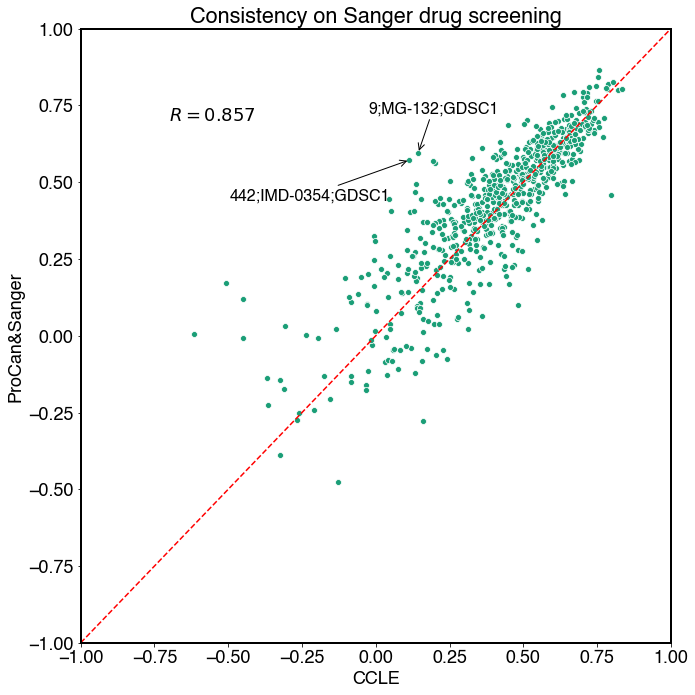

In [32]:
fig = plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x='CCLE', y='ProCan&Sanger', data=sanger_all_drug_scatter)
plt.plot((-1, 1), (-1, 1), ls="--", c='red')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.text(
    -0.7, 0.7,
    f"$R={pearsonr(sanger_all_drug_scatter['CCLE'], sanger_all_drug_scatter['ProCan&Sanger'])[0]:.3f}$"
)
ax.annotate(f'442;IMD-0354;GDSC1',
            xy=(0.113708, 0.572220),
            xycoords='data',
            xytext=(-180, -40),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->"),
            fontsize=16)
ax.annotate(f'9;MG-132;GDSC1',
            xy=(0.143898, 0.595813),
            xycoords='data',
            xytext=(-50, 40),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->"),
            fontsize=16)
plt.title("Consistency on Sanger drug screening")
plt.tight_layout()
plt.savefig("../plots/drug/vs_ccle_sangerdrug_scatter.pdf", dpi=500)

In [69]:
sanger_all_drug_scatter.to_csv("../plots/plot_data/SuppFig8B_scatter_sanger_vs_ccle_drug.csv")

In [44]:
pearsonr(ccle_all_drug_scatter['CCLE'], ccle_all_drug_scatter['ProCan&Sanger'])

(0.5083821804565619, 3.6740387726016854e-92)

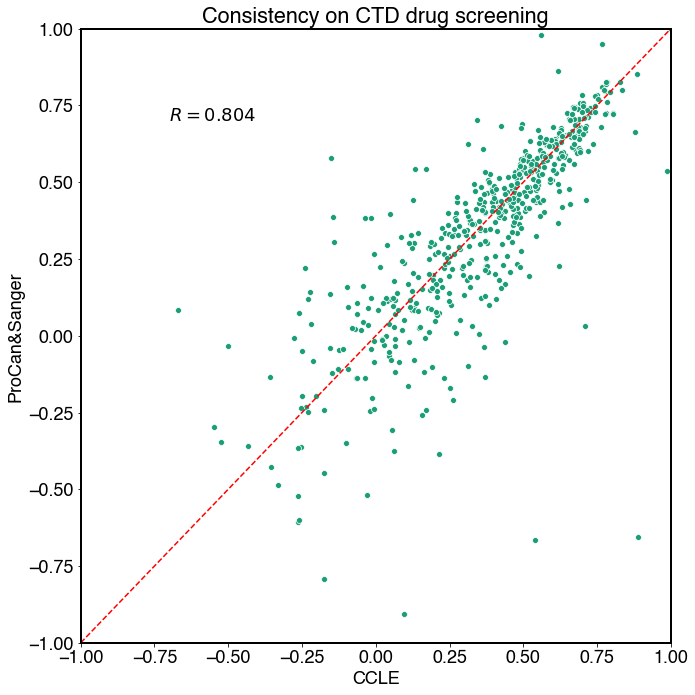

In [30]:
ctd_all_drug_scatter = pd.pivot(
    ctd_all_drug[['drug_id', 'test_corr', 'protein_data']],
    index='drug_id',
    columns='protein_data',
    values='test_corr')
fig = plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x='CCLE', y='ProCan&Sanger', data=ctd_all_drug_scatter)
plt.plot((-1, 1), (-1, 1), ls="--", c='red')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.text(
    -0.7, 0.7,
    f"$R={pearsonr(ctd_all_drug_scatter['CCLE'], ctd_all_drug_scatter['ProCan&Sanger'])[0]:.3f}$"
)

plt.title("Consistency on CTD drug screening")
plt.tight_layout()
plt.savefig("../plots/drug/vs_ccle_ctddrug_scatter.pdf", dpi=500)

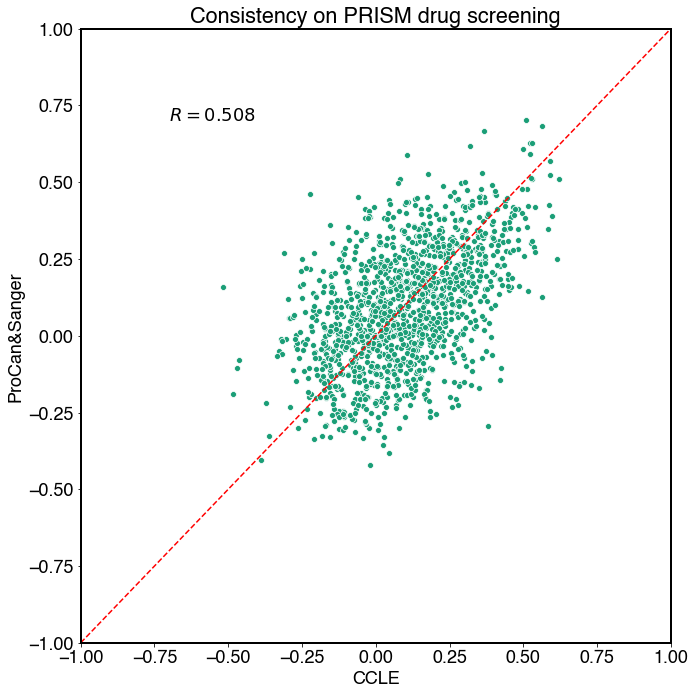

In [31]:
ccle_all_drug_scatter = pd.pivot(
    ccle_all_drug[['drug_id', 'test_corr', 'protein_data']],
    index='drug_id',
    columns='protein_data',
    values='test_corr')
fig = plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x='CCLE', y='ProCan&Sanger', data=ccle_all_drug_scatter)
plt.plot((-1, 1), (-1, 1), ls="--", c='red')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.text(
    -0.7, 0.7,
    f"$R={pearsonr(ccle_all_drug_scatter['CCLE'], ccle_all_drug_scatter['ProCan&Sanger'])[0]:.3f}$"
)

plt.title("Consistency on PRISM drug screening")
plt.tight_layout()
plt.savefig("../plots/drug/vs_ccle_ccledrug_scatter.pdf", dpi=500)

## common drugs

In [97]:
sanger_drug_common = pd.read_csv("../data/drug/ccle_common_final_drug.csv")
ccle_drug_common = pd.read_csv("../data/ccle/sanger_common_final_drug_auc.csv")

/Users/scai/anaconda3/envs/sanger/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (34) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [98]:
sanger_common_drug = sanger_all_drug[sanger_all_drug['drug_id'].isin(sanger_drug_common['drug_id'].unique())]
ccle_common_drug = ccle_all_drug[ccle_all_drug['drug_id'].isin(ccle_drug_common['drug_id'].unique())]

Text(0, 0.5, '')

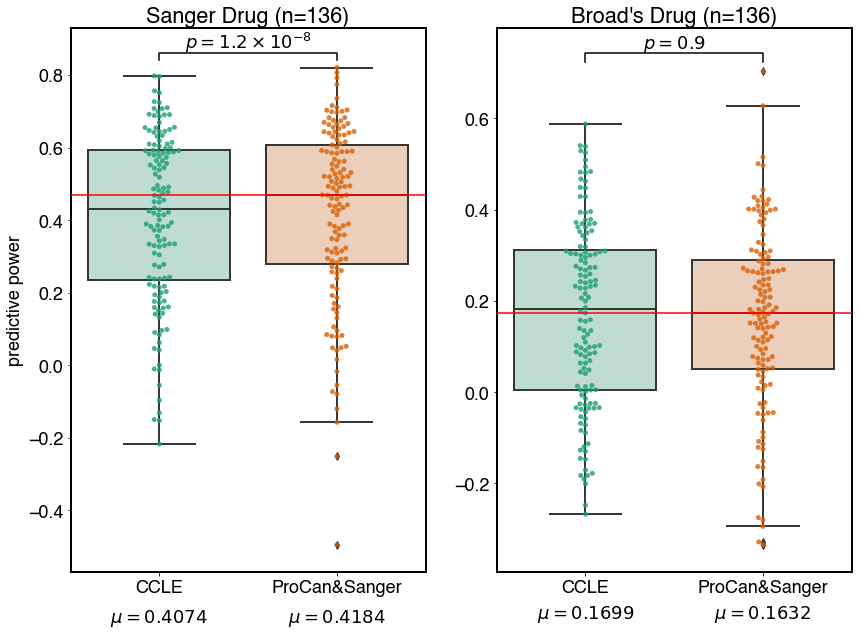

In [99]:
fig, ax = plt.subplots(1, 2, figsize=(14, 10))

ga = sns.boxplot('protein_data',
                 'test_corr',
                 data=sanger_common_drug,
                 orient='v',
                 linewidth=2,
                 ax=ax[0])
for patch in ga.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))

sns.swarmplot('protein_data',
              'test_corr',
              data=sanger_common_drug,
              orient='vh',
              alpha=.8,
              ax=ax[0])

x1, x2 = 0, 1  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = sanger_common_drug['test_corr'].max() + 0.02, 0.02, 'k'
ax[0].plot([x1, x1, x2, x2], [y, y + w, y + w, y], lw=1.5, c=col)
ax[0].text((x1 + x2) * .5,
           y + w + 0.03,
           r"$p=1.2\times10^{-8}$",
           ha='center',
           va='center',
           color=col)
ax[0].text(
    0,
    sanger_common_drug['test_corr'].min() - 0.2,
    f"$\mu={sanger_common_drug[sanger_common_drug['protein_data']=='CCLE']['test_corr'].mean():.4f}$",
    ha='center',
    va='center')
ax[0].text(
    1,
    sanger_common_drug['test_corr'].min() - 0.2,
    f"$\mu={sanger_common_drug[sanger_common_drug['protein_data']=='ProCan&Sanger']['test_corr'].mean():.4f}$",
    ha='center',
    va='center')
y = sanger_common_drug[sanger_common_drug['protein_data'] ==
                    'ProCan&Sanger']['test_corr'].median()
ax[0].plot((-0.5, 2.5), [y, y], color='red', zorder=10)

ga = sns.boxplot('protein_data',
                 'test_corr',
                 data=ccle_common_drug,
                 orient='v',
                 linewidth=2,
                 ax=ax[1])
for patch in ga.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))

sns.swarmplot('protein_data',
              'test_corr',
              data=ccle_common_drug,
              orient='vh',
              alpha=.8,
              ax=ax[1])

x1, x2 = 0, 1  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = ccle_common_drug['test_corr'].max() + 0.02, 0.02, 'k'
ax[1].plot([x1, x1, x2, x2], [y, y + w, y + w, y], lw=1.5, c=col)
ax[1].text((x1 + x2) * .5,
           y + w + 0.02,
           r"$p=0.9$",
           ha='center',
           va='center',
           color=col)
y = ccle_common_drug[ccle_common_drug['protein_data'] ==
                  'ProCan&Sanger']['test_corr'].median()
ax[1].plot((-0.5, 2.5), [y, y], color='red', zorder=10)
ax[1].text(
    0,
    ccle_common_drug['test_corr'].min() - 0.15,
    f"$\mu={ccle_common_drug[ccle_common_drug['protein_data']=='CCLE']['test_corr'].mean():.4f}$",
    ha='center',
    va='center')
ax[1].text(
    1,
    ccle_common_drug['test_corr'].min() - 0.15,
    f"$\mu={ccle_common_drug[ccle_common_drug['protein_data']=='ProCan&Sanger']['test_corr'].mean():.4f}$",
    ha='center',
    va='center')

ax[0].set_title(f"Sanger Drug (n={sanger_common_drug['drug_id'].unique().size})")
ax[1].set_title(f"Broad's Drug (n={ccle_common_drug['drug_id'].unique().size})")
ax[0].set_xlabel("")
ax[1].set_xlabel("")
ax[0].set_ylabel("predictive power")
ax[1].set_ylabel("")

## crispr all

In [21]:
ccle_score_sanger_crispr = pd.read_csv(
    "../work_dirs/crispr/protein_vs_ccle/RandomForest/scores_202009121630_ccle.csv"
)
sanger_score_sanger_crispr = pd.read_csv(
    "../work_dirs/crispr/protein_vs_ccle/RandomForest/scores_202009121629_sanger.csv"
)
ccle_score_sanger_crispr['protein_data'] = 'CCLE'
sanger_score_sanger_crispr['protein_data'] = 'ProCan&Sanger'

sanger_all_crispr = pd.concat([ccle_score_sanger_crispr, sanger_score_sanger_crispr])

In [22]:
ttest_rel(sanger_all_crispr[sanger_all_crispr['protein_data']=='CCLE']['test_corr'].values,
          sanger_all_crispr[sanger_all_crispr['protein_data']=='ProCan&Sanger']['test_corr'].values)

Ttest_relResult(statistic=-3.1743986476143946, pvalue=0.0015041774346624273)

In [23]:
sanger_all_crispr = sanger_all_crispr[['Gene', 'test_corr','protein_data']]

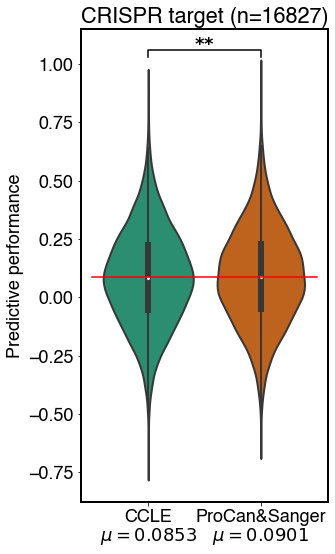

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(5, 8), sharey=True)

ga = sns.violinplot('protein_data',
                 'test_corr',
                 data=sanger_all_crispr,
                 orient='v',
                 linewidth=2,
                 ax=ax)
# for patch in ga.artists:
#     r, g, b, a = patch.get_facecolor()
#     patch.set_facecolor((r, g, b, .3))

# sns.swarmplot('protein_data',
#               'test_corr',
#               data=sanger_all_crispr,
#               orient='vh',
#               alpha=.8,
#               ax=ax)

x1, x2 = 0, 1  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = sanger_all_crispr['test_corr'].max() + 0.07, 0.03, 'k'
ax.plot([x1, x1, x2, x2], [y, y + w, y + w, y], lw=1.5, c=col)
ax.text((x1 + x2) * .5,
           y + w + 0.03,
           r"$\bf{*}\bf{*}$",
           ha='center',
           va='center',
           color=col)
ax.text(
    0,
    sanger_all_crispr['test_corr'].min() - 0.3,
    f"$\mu={sanger_all_crispr[sanger_all_crispr['protein_data']=='CCLE']['test_corr'].mean():.4f}$",
    ha='center',
    va='center')
ax.text(
    1,
    sanger_all_crispr['test_corr'].min() - 0.3,
    f"$\mu={sanger_all_crispr[sanger_all_crispr['protein_data']=='ProCan&Sanger']['test_corr'].mean():.4f}$",
    ha='center',
    va='center')
y = sanger_all_crispr[sanger_all_crispr['protein_data'] ==
                    'ProCan&Sanger']['test_corr'].median()
ax.plot((-0.5, 1.5), [y, y], color='red', zorder=10)

ax.set_title(f"CRISPR target (n={sanger_all_crispr['Gene'].unique().size})")
ax.set_xlabel("")
ax.set_ylabel("Predictive performance")
plt.tight_layout()
# plt.savefig("../plots/drug/sanger_vs_ccle.pdf", dpi=500)

In [43]:
sanger_all_crispr.to_csv("../plots/plot_data/Fig4C_crispr_vs_ccle.csv",
                         index=False)

In [11]:
sanger_all_crispr_scatter = pd.pivot(
    sanger_all_crispr[['Gene', 'test_corr', 'protein_data']],
    index='Gene',
    columns='protein_data',
    values='test_corr')

sanger_all_crispr_scatter['delta'] = sanger_all_crispr_scatter[
    'ProCan&Sanger'] - sanger_all_crispr_scatter['CCLE']

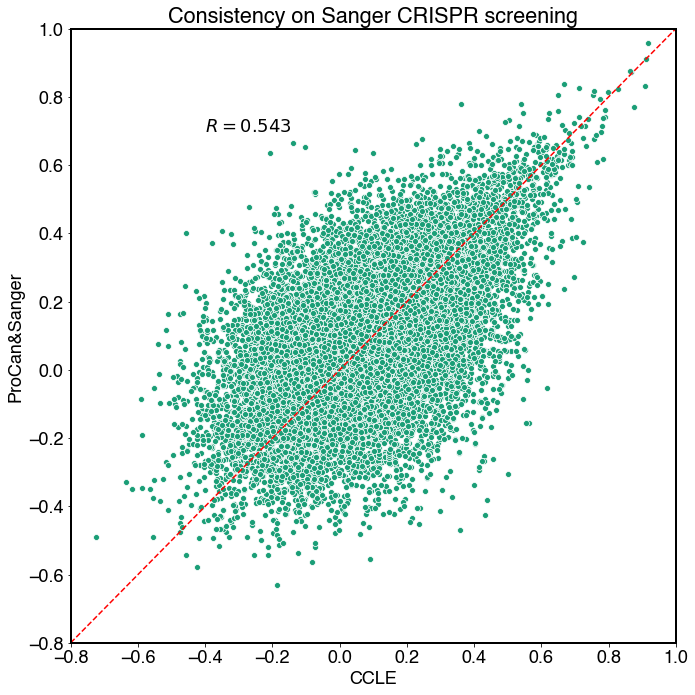

In [16]:
fig = plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x='CCLE', y='ProCan&Sanger', data=sanger_all_crispr_scatter)
plt.plot((-0.8, 1), (-0.8, 1), ls="--", c='red')
plt.xlim(-0.8, 1)
plt.ylim(-0.8, 1)
plt.text(
    -0.4, 0.7,
    f"$R={pearsonr(sanger_all_crispr_scatter['CCLE'], sanger_all_crispr_scatter['ProCan&Sanger'])[0]:.3f}$"
)
# ax.annotate(f'442;IMD-0354;GDSC1',
#             xy=(0.113708, 0.572220),
#             xycoords='data',
#             xytext=(-180, -40),
#             textcoords='offset points',
#             arrowprops=dict(arrowstyle="->"),
#             fontsize=16)
# ax.annotate(f'9;MG-132;GDSC1',
#             xy=(0.143898, 0.595813),
#             xycoords='data',
#             xytext=(-50, 40),
#             textcoords='offset points',
#             arrowprops=dict(arrowstyle="->"),
#             fontsize=16)
plt.title("Consistency on Sanger CRISPR screening")
plt.tight_layout()
# plt.savefig("../plots/crispr/vs_ccle_sangercrispr_scatter.pdf", dpi=500)

In [46]:
sanger_all_crispr_scatter.to_csv("../plots/plot_data/SuppFig8C_scatter_sanger_vs_ccle_crispr.csv")

# feature importance comparison

In [ ]:
sanger_feature = pd.read_csv("../work_dirs/vs_ccle_ccledrug/RandomForest/")

# CCLE correlate with RNA

In [ ]:
combined_noblood = combined[combined['Tissue_type']!='Haematopoietic and Lymphoid']
combined_blood = combined[combined['Tissue_type']=='Haematopoietic and Lymphoid']

In [51]:
ccle_protein_common = ccle_protein[ccle_protein['Cell_line'].isin(common_cell_lines)].set_index(['Cell_line'])
ccle_protein_common = ccle_protein_common[common_proteins]
ccle_protein_common = ccle_protein_common.reset_index()
ccle_protein_common = ccle_protein_common.drop_duplicates(['Cell_line'])

In [52]:
name_map = pd.read_csv("../data/misc/HUMAN_9606_idmapping.gene_prot.dat",
                       sep='\t',
                       names=['ID', 'type', 'code'])
name_map = name_map.drop_duplicates(['ID', 'type'])
name_map = pd.pivot(name_map, index='ID', columns='type', values='code').dropna()

In [53]:
name_map_dict = dict(zip(name_map['UniProtKB-ID'].values, name_map['Gene_Name'].values))

In [54]:
rna_raw = pd.read_csv("../data/rna/rnaseq_voom.csv", index_col=0).T

rna_raw.index.name='SIDM'

rna_raw = rna_raw.reset_index()

In [55]:
rna_sample = pd.merge(rna_raw,
                      meta[['SIDM',
                            'Cell_line']].drop_duplicates()).drop(['SIDM'],
                                                                  axis=1)

In [42]:
corr_dict = {}
gene_not_found = []
protein_not_found = []
for protein in ccle_protein_common.drop(['Cell_line'], axis=1).columns:
    if protein not in name_map_dict:
        protein_not_found.append(protein)
        continue
    gene = name_map_dict[protein]
    if gene in rna_sample.columns:
        data = pd.merge(ccle_protein_common[['Cell_line', protein]],
                        rna_sample[['Cell_line', gene]])
        data = data.dropna()
        corr_dict[protein] = pearsonr(data.iloc[:, 1], data.iloc[:, 2])[0]


In [43]:
np.median(list(corr_dict.values()))

0.543877409264814

Text(-0.3472845380173486, 200, 'Median: 0.5439')

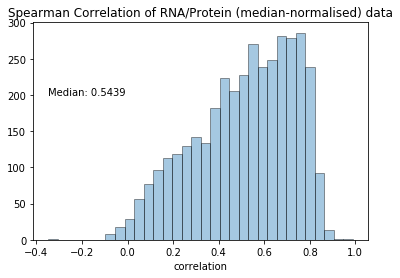

In [44]:
sns.distplot(list(corr_dict.values()),
             kde=False,
             hist_kws=dict(edgecolor="k", linewidth=1))
plt.title("Spearman Correlation of RNA/Protein (median-normalised) data")
plt.xlabel("correlation")
plt.text(np.min(list(corr_dict.values())), 200,
         f"Median: {np.median(list(corr_dict.values())):.4f}")

/Users/scai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/scai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Text(0, 0.5, 'EGFR_RNA')

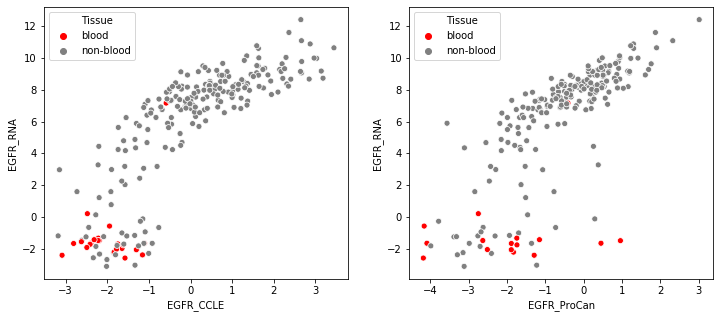

In [95]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ccle_egfr = ccle_protein_common[['Cell_line', 'EGFR_HUMAN']]
ccle_egfr['Tissue'] = ccle_egfr['Cell_line'].map(
    lambda x: 'blood' if x in combined_blood['Cell_line'].values else 'non-blood')

combined_egfr = pd.merge(ccle_egfr, rna_sample[['Cell_line', 'EGFR']])

sns.scatterplot(x='EGFR_HUMAN', y='EGFR', hue='Tissue', data=combined_egfr, palette=['red', 'grey'],ax=ax[0])

sanger_egfr = sanger_protein_common[['Cell_line', 'EGFR_HUMAN']]
sanger_egfr['Tissue'] = sanger_egfr['Cell_line'].map(
    lambda x: 'blood' if x in combined_blood['Cell_line'].values else 'non-blood')

combined_egfr = pd.merge(sanger_egfr, rna_sample[['Cell_line', 'EGFR']])

sns.scatterplot(x='EGFR_HUMAN', y='EGFR', hue='Tissue', data=combined_egfr, palette=['red', 'grey'],ax=ax[1])

ax[0].set_xlabel("EGFR_CCLE")
ax[0].set_ylabel("EGFR_RNA")
ax[1].set_xlabel("EGFR_ProCan")
ax[1].set_ylabel("EGFR_RNA")

/Users/scai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/scai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Text(0, 0.5, 'MET_RNA')

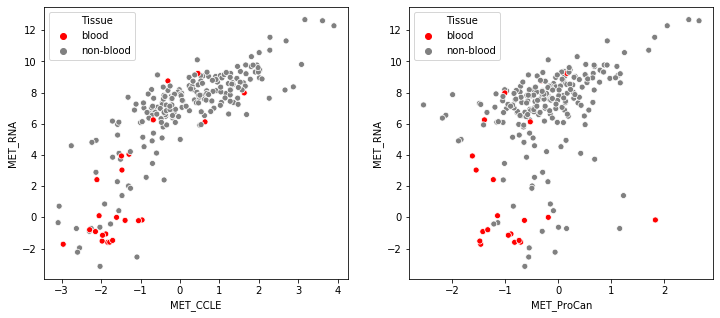

In [96]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ccle_egfr = ccle_protein_common[['Cell_line', 'MET_HUMAN']]
ccle_egfr['Tissue'] = ccle_egfr['Cell_line'].map(
    lambda x: 'blood' if x in combined_blood['Cell_line'].values else 'non-blood')

combined_egfr = pd.merge(ccle_egfr, rna_sample[['Cell_line', 'MET']])

sns.scatterplot(x='MET_HUMAN', y='MET', hue='Tissue', data=combined_egfr, palette=['red', 'grey'],ax=ax[0])

sanger_egfr = sanger_protein_common[['Cell_line', 'MET_HUMAN']]
sanger_egfr['Tissue'] = sanger_egfr['Cell_line'].map(
    lambda x: 'blood' if x in combined_blood['Cell_line'].values else 'non-blood')

combined_egfr = pd.merge(sanger_egfr, rna_sample[['Cell_line', 'MET']])

sns.scatterplot(x='MET_HUMAN', y='MET', hue='Tissue', data=combined_egfr, palette=['red', 'grey'],ax=ax[1])

ax[0].set_xlabel("MET_CCLE")
ax[0].set_ylabel("MET_RNA")
ax[1].set_xlabel("MET_ProCan")
ax[1].set_ylabel("MET_RNA")